In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import sciann as sn
from sciann import math as snm

Using TensorFlow backend.


---------------------- SCIANN 0.4.6.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [3]:
import sys
sys.path.append('../../')
import src
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils
import src.eikonal as eikonal
from tqdm.notebook import tqdm
import datetime

In [4]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)

dx, dz = x[1] - x[0], z[1] - z[0]
X, Z = np.meshgrid(x, z, indexing='ij')

In [5]:
# Source
ixs, izs = 25, 25
sid = (ixs, izs)
rav_sid = np.ravel_multi_index(sid, (nx, nz))
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
sou_xz = np.array(sou, ndmin=2)

# Grid
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

# Velocity
vmin, vmax = 1000.0, 4000.0
a = (vmax - vmin) / z.max()
V = eikonal.vel_func(vmin, a)(Z)
V_scaled = V / vmax

# Solution
T = eikonal.t_vgrad(X, Z, xs, zs, vmin, a)

# Indices for additinal bounds
new_inds = np.array([(ixs - 1, izs), (ixs + 1, izs), (ixs, izs - 1), (ixs, izs + 1)])
inds = np.vstack((new_inds, [[ixs, izs]]))
rav_inds = np.ravel_multi_index(inds.T, (nx, nz))

# Gradient
tau_grad = eikonal.t_vfield_vgrad(X, Z, xs, zs, vmin, a)
tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
tau_grad /= tau_modul

../..\src\eikonal\helpers.py:87: RuntimeWarning: divide by zero encountered in true_divide
  A = 1 / a / np.sqrt((up / down + 1)**2 - 1)
../..\src\eikonal\helpers.py:88: RuntimeWarning: invalid value encountered in multiply
  dt_dx = 2 * a**2 * Xdiff / down * A
../..\src\eikonal\helpers.py:89: RuntimeWarning: invalid value encountered in multiply
  dt_dz = (2 * a**2 * Zdiff / down - 2 * a * Vxszs * up / down**2) * A


In [69]:
v0 = 2500.0
T_homo = np.sqrt(X_shift**2 + Z_shift**2) / v0

In [70]:
x_data = X_shift.ravel()
z_data = Z_shift.ravel()
t_true = T_homo.ravel()

Sl = 1 / v_data

In [71]:
def eikonal_inv(nu=50, nl=4, act='tanh'):
    # Inputs
    x = sn.Variable('x')
    z = sn.Variable('z')
    
    # Velocity
    v = sn.Parameter(val=3500.0, inputs=[x, z], min_max=[400.0, 7000.0], name='Velocity')
    
    # Traveltime
    T = sn.Functional('Traveltime', [x, z], [nu]*nl, act)

    # Eikonal
    Tx = snm.diff(T, x)
    Tz = snm.diff(T, z)
    Tr2 = Tx**2 + Tz**2
    E = Tr2 - 1 / v**2

    # Positivity
    P = snm.relu(-T)

    # Monotonicity
    Tr = snm.sqrt(Tr2) + 1e-16
    r = snm.sqrt(x**2 + z**2) + 1e-16
    scal = Tx * x + Tz * z
    M = scal / r / Tr
    M = snm.relu(-M)

    # Laplacian
    Txx, Tzz = snm.diff(Tx, x), snm.diff(Tz, z)
    L = Txx + Tzz
    L = snm.abs(L)
    
    # Model and outputs
    outputs = [T, E, M, v]
    names = ['T', 'E', 'M', 'v']
    model = sn.SciModel([x, z], [T, E, M])
    outs = {n:val for n, val in zip(names, outputs)}
    return model, outs

In [53]:
# Indices except SOURCE POINT for Eikonal, Monotonicity, Laplace etc
eq_ids = np.arange(0, nx*nz, 1, dtype=int)
eq_ids = eq_ids[eq_ids != rav_sid]
b_ids = np.array([rav_sid])

In [80]:
# model, outs = eikonal_inv()
h = model.train(x_true = [x_data, z_data],
                y_true = [t_true, (eq_ids, 'zero'), (eq_ids, 'zero')], 
                target_weights = [10.0, 1e5, 10.0],
                epochs=10000, verbose=1, batch_size=nx*nz, 
                learning_rate=1e-3)

Epoch 1/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.4942 - Traveltime_loss: 0.4325 - sub/464_loss: 0.0247 - relu/480_loss: 0.0371
Epoch 2/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.4855 - Traveltime_loss: 0.4321 - sub/464_loss: 0.0222 - relu/480_loss: 0.0312
Epoch 3/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.4915 - Traveltime_loss: 0.4359 - sub/464_loss: 0.0207 - relu/480_loss: 0.0349
Epoch 4/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.5007 - Traveltime_loss: 0.4448 - sub/464_loss: 0.0197 - relu/480_loss: 0.0363
Epoch 5/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.5175 - Traveltime_loss: 0.4498 - sub/464_loss: 0.0190 - relu/480_loss: 0.0487
Epoch 6/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.5235 - Traveltime_loss: 0.4542 - sub/464_loss: 0.0185 - relu/480_loss: 0.0507
Epoch 7/10000
2601/2601 [=================

Epoch 52/10000
2601/2601 [==============================] - 0s 14us/step - loss: 0.2344 - Traveltime_loss: 0.1985 - sub/464_loss: 0.0065 - relu/480_loss: 0.0294
Epoch 53/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2379 - Traveltime_loss: 0.1978 - sub/464_loss: 0.0063 - relu/480_loss: 0.0338
Epoch 54/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2299 - Traveltime_loss: 0.1961 - sub/464_loss: 0.0060 - relu/480_loss: 0.0277
Epoch 55/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2238 - Traveltime_loss: 0.1922 - sub/464_loss: 0.0058 - relu/480_loss: 0.0259
Epoch 56/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.2255 - Traveltime_loss: 0.1866 - sub/464_loss: 0.0056 - relu/480_loss: 0.0334
Epoch 57/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2082 - Traveltime_loss: 0.1799 - sub/464_loss: 0.0054 - relu/480_loss: 0.0230
Epoch 58/10000
2601/2601 [=========

Epoch 103/10000
2601/2601 [==============================] - 0s 16us/step - loss: 0.1334 - Traveltime_loss: 0.1122 - sub/464_loss: 0.0017 - relu/480_loss: 0.0195
Epoch 104/10000
2601/2601 [==============================] - 0s 13us/step - loss: 0.1422 - Traveltime_loss: 0.1167 - sub/464_loss: 0.0016 - relu/480_loss: 0.0239
Epoch 105/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.1443 - Traveltime_loss: 0.1186 - sub/464_loss: 0.0016 - relu/480_loss: 0.0242
Epoch 106/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.1449 - Traveltime_loss: 0.1183 - sub/464_loss: 0.0015 - relu/480_loss: 0.0250
Epoch 107/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.1463 - Traveltime_loss: 0.1165 - sub/464_loss: 0.0015 - relu/480_loss: 0.0283
Epoch 108/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1405 - Traveltime_loss: 0.1139 - sub/464_loss: 0.0015 - relu/480_loss: 0.0250
Epoch 109/10000
2601/2601 [=

Epoch 154/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1008 - Traveltime_loss: 0.0791 - sub/464_loss: 0.0027 - relu/480_loss: 0.0190
Epoch 155/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.1033 - Traveltime_loss: 0.0777 - sub/464_loss: 0.0029 - relu/480_loss: 0.0227
Epoch 156/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1016 - Traveltime_loss: 0.0768 - sub/464_loss: 0.0030 - relu/480_loss: 0.0218
Epoch 157/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1053 - Traveltime_loss: 0.0765 - sub/464_loss: 0.0030 - relu/480_loss: 0.0258
Epoch 158/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1054 - Traveltime_loss: 0.0764 - sub/464_loss: 0.0030 - relu/480_loss: 0.0260
Epoch 159/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1060 - Traveltime_loss: 0.0764 - sub/464_loss: 0.0029 - relu/480_loss: 0.0267
Epoch 160/10000
2601/2601 [===

Epoch 205/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0894 - Traveltime_loss: 0.0717 - sub/464_loss: 0.0016 - relu/480_loss: 0.0161
Epoch 206/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.0878 - Traveltime_loss: 0.0715 - sub/464_loss: 0.0016 - relu/480_loss: 0.0147
Epoch 207/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0880 - Traveltime_loss: 0.0712 - sub/464_loss: 0.0016 - relu/480_loss: 0.0153
Epoch 208/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0879 - Traveltime_loss: 0.0708 - sub/464_loss: 0.0015 - relu/480_loss: 0.0155
Epoch 209/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0865 - Traveltime_loss: 0.0703 - sub/464_loss: 0.0016 - relu/480_loss: 0.0146
Epoch 210/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0860 - Traveltime_loss: 0.0699 - sub/464_loss: 0.0016 - relu/480_loss: 0.0146
Epoch 211/10000
2601/2601 [=====

Epoch 256/10000
2601/2601 [==============================] - 0s 13us/step - loss: 0.0740 - Traveltime_loss: 0.0600 - sub/464_loss: 0.0012 - relu/480_loss: 0.0128
Epoch 257/10000
2601/2601 [==============================] - 0s 14us/step - loss: 0.0739 - Traveltime_loss: 0.0599 - sub/464_loss: 0.0012 - relu/480_loss: 0.0128
Epoch 258/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0739 - Traveltime_loss: 0.0597 - sub/464_loss: 0.0012 - relu/480_loss: 0.0130
Epoch 259/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0734 - Traveltime_loss: 0.0595 - sub/464_loss: 0.0012 - relu/480_loss: 0.0127
Epoch 260/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0731 - Traveltime_loss: 0.0594 - sub/464_loss: 0.0012 - relu/480_loss: 0.0126
Epoch 261/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0731 - Traveltime_loss: 0.0592 - sub/464_loss: 0.0012 - relu/480_loss: 0.0127
Epoch 262/10000
2601/2601 [=

Epoch 306/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0669 - Traveltime_loss: 0.0538 - sub/464_loss: 8.2575e-04 - relu/480_loss: 0.0123
Epoch 307/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0678 - Traveltime_loss: 0.0537 - sub/464_loss: 8.2793e-04 - relu/480_loss: 0.0132
Epoch 308/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0664 - Traveltime_loss: 0.0536 - sub/464_loss: 8.3062e-04 - relu/480_loss: 0.0120
Epoch 309/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0665 - Traveltime_loss: 0.0535 - sub/464_loss: 8.3332e-04 - relu/480_loss: 0.0122
Epoch 310/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0665 - Traveltime_loss: 0.0533 - sub/464_loss: 8.3571e-04 - relu/480_loss: 0.0124
Epoch 311/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0664 - Traveltime_loss: 0.0532 - sub/464_loss: 8.3756e-04 - relu/480_loss: 0.0124
Epoch

Epoch 356/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0610 - Traveltime_loss: 0.0494 - sub/464_loss: 6.3880e-04 - relu/480_loss: 0.0109
Epoch 357/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0610 - Traveltime_loss: 0.0493 - sub/464_loss: 6.3440e-04 - relu/480_loss: 0.0110
Epoch 358/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0608 - Traveltime_loss: 0.0492 - sub/464_loss: 6.3017e-04 - relu/480_loss: 0.0109
Epoch 359/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0607 - Traveltime_loss: 0.0492 - sub/464_loss: 6.2609e-04 - relu/480_loss: 0.0109
Epoch 360/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0606 - Traveltime_loss: 0.0491 - sub/464_loss: 6.2217e-04 - relu/480_loss: 0.0109
Epoch 361/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0604 - Traveltime_loss: 0.0490 - sub/464_loss: 6.1838e-04 - relu/480_loss: 0.0108
Epoch

Epoch 406/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0567 - Traveltime_loss: 0.0464 - sub/464_loss: 4.8593e-04 - relu/480_loss: 0.0098
Epoch 407/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0567 - Traveltime_loss: 0.0463 - sub/464_loss: 4.8363e-04 - relu/480_loss: 0.0099
Epoch 408/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0566 - Traveltime_loss: 0.0463 - sub/464_loss: 4.8136e-04 - relu/480_loss: 0.0099
Epoch 409/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0569 - Traveltime_loss: 0.0462 - sub/464_loss: 4.7911e-04 - relu/480_loss: 0.0102
Epoch 410/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0565 - Traveltime_loss: 0.0462 - sub/464_loss: 4.7691e-04 - relu/480_loss: 0.0099
Epoch 411/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0566 - Traveltime_loss: 0.0461 - sub/464_loss: 4.7472e-04 - relu/480_loss: 0.0101
Epoch 

Epoch 456/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0536 - Traveltime_loss: 0.0440 - sub/464_loss: 3.9376e-04 - relu/480_loss: 0.0092
Epoch 457/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0534 - Traveltime_loss: 0.0440 - sub/464_loss: 3.9222e-04 - relu/480_loss: 0.0091
Epoch 458/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0534 - Traveltime_loss: 0.0439 - sub/464_loss: 3.9067e-04 - relu/480_loss: 0.0091
Epoch 459/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0534 - Traveltime_loss: 0.0439 - sub/464_loss: 3.8913e-04 - relu/480_loss: 0.0091
Epoch 460/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0533 - Traveltime_loss: 0.0438 - sub/464_loss: 3.8760e-04 - relu/480_loss: 0.0091
Epoch 461/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0533 - Traveltime_loss: 0.0438 - sub/464_loss: 3.8609e-04 - relu/480_loss: 0.0091
Epoch

Epoch 506/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0537 - Traveltime_loss: 0.0442 - sub/464_loss: 3.3633e-04 - relu/480_loss: 0.0092
Epoch 507/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.0534 - Traveltime_loss: 0.0438 - sub/464_loss: 3.2707e-04 - relu/480_loss: 0.0093
Epoch 508/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0532 - Traveltime_loss: 0.0436 - sub/464_loss: 3.1858e-04 - relu/480_loss: 0.0093
Epoch 509/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0530 - Traveltime_loss: 0.0434 - sub/464_loss: 3.1224e-04 - relu/480_loss: 0.0093
Epoch 510/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0528 - Traveltime_loss: 0.0433 - sub/464_loss: 3.0647e-04 - relu/480_loss: 0.0092
Epoch 511/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0528 - Traveltime_loss: 0.0432 - sub/464_loss: 3.0132e-04 - relu/480_loss: 0.0093
Epoch 51

Epoch 556/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0492 - Traveltime_loss: 0.0410 - sub/464_loss: 2.7981e-04 - relu/480_loss: 0.0078
Epoch 557/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0491 - Traveltime_loss: 0.0410 - sub/464_loss: 2.7892e-04 - relu/480_loss: 0.0078
Epoch 558/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0491 - Traveltime_loss: 0.0410 - sub/464_loss: 2.7803e-04 - relu/480_loss: 0.0078
Epoch 559/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0490 - Traveltime_loss: 0.0410 - sub/464_loss: 2.7714e-04 - relu/480_loss: 0.0078
Epoch 560/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0490 - Traveltime_loss: 0.0409 - sub/464_loss: 2.7626e-04 - relu/480_loss: 0.0078
Epoch 561/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0489 - Traveltime_loss: 0.0409 - sub/464_loss: 2.7539e-04 - relu/480_loss: 0.0077
Epoch 56

Epoch 606/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0476 - Traveltime_loss: 0.0397 - sub/464_loss: 2.5334e-04 - relu/480_loss: 0.0077
Epoch 607/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0475 - Traveltime_loss: 0.0396 - sub/464_loss: 2.5296e-04 - relu/480_loss: 0.0076
Epoch 608/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0475 - Traveltime_loss: 0.0396 - sub/464_loss: 2.5258e-04 - relu/480_loss: 0.0076
Epoch 609/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0475 - Traveltime_loss: 0.0396 - sub/464_loss: 2.5219e-04 - relu/480_loss: 0.0076
Epoch 610/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0474 - Traveltime_loss: 0.0396 - sub/464_loss: 2.5181e-04 - relu/480_loss: 0.0076
Epoch 611/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0474 - Traveltime_loss: 0.0395 - sub/464_loss: 2.5142e-04 - relu/480_loss: 0.0076
Epoch 

Epoch 656/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0463 - Traveltime_loss: 0.0386 - sub/464_loss: 2.3474e-04 - relu/480_loss: 0.0075
Epoch 657/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0463 - Traveltime_loss: 0.0386 - sub/464_loss: 2.3442e-04 - relu/480_loss: 0.0075
Epoch 658/10000
2601/2601 [==============================] - 0s 13us/step - loss: 0.0462 - Traveltime_loss: 0.0386 - sub/464_loss: 2.3411e-04 - relu/480_loss: 0.0074
Epoch 659/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0462 - Traveltime_loss: 0.0386 - sub/464_loss: 2.3381e-04 - relu/480_loss: 0.0074
Epoch 660/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0462 - Traveltime_loss: 0.0385 - sub/464_loss: 2.3352e-04 - relu/480_loss: 0.0075
Epoch 661/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0462 - Traveltime_loss: 0.0385 - sub/464_loss: 2.3323e-04 - relu/480_loss: 0.0074
Epoc

Epoch 706/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0453 - Traveltime_loss: 0.0378 - sub/464_loss: 2.2083e-04 - relu/480_loss: 0.0073
Epoch 707/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0453 - Traveltime_loss: 0.0378 - sub/464_loss: 2.2057e-04 - relu/480_loss: 0.0073
Epoch 708/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0453 - Traveltime_loss: 0.0378 - sub/464_loss: 2.2030e-04 - relu/480_loss: 0.0073
Epoch 709/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0452 - Traveltime_loss: 0.0378 - sub/464_loss: 2.2004e-04 - relu/480_loss: 0.0073
Epoch 710/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0453 - Traveltime_loss: 0.0377 - sub/464_loss: 2.1978e-04 - relu/480_loss: 0.0073
Epoch 711/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0452 - Traveltime_loss: 0.0377 - sub/464_loss: 2.1952e-04 - relu/480_loss: 0.0073
Epoch

Epoch 756/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0445 - Traveltime_loss: 0.0371 - sub/464_loss: 2.0801e-04 - relu/480_loss: 0.0071
Epoch 757/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0444 - Traveltime_loss: 0.0371 - sub/464_loss: 2.0774e-04 - relu/480_loss: 0.0071
Epoch 758/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0444 - Traveltime_loss: 0.0371 - sub/464_loss: 2.0746e-04 - relu/480_loss: 0.0071
Epoch 759/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0444 - Traveltime_loss: 0.0371 - sub/464_loss: 2.0717e-04 - relu/480_loss: 0.0071
Epoch 760/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0444 - Traveltime_loss: 0.0371 - sub/464_loss: 2.0688e-04 - relu/480_loss: 0.0071
Epoch 761/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0444 - Traveltime_loss: 0.0371 - sub/464_loss: 2.0659e-04 - relu/480_loss: 0.0071
Epoch 76

Epoch 806/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0437 - Traveltime_loss: 0.0365 - sub/464_loss: 1.9546e-04 - relu/480_loss: 0.0070
Epoch 807/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0437 - Traveltime_loss: 0.0365 - sub/464_loss: 1.9521e-04 - relu/480_loss: 0.0070
Epoch 808/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0437 - Traveltime_loss: 0.0365 - sub/464_loss: 1.9497e-04 - relu/480_loss: 0.0070
Epoch 809/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0436 - Traveltime_loss: 0.0365 - sub/464_loss: 1.9474e-04 - relu/480_loss: 0.0069
Epoch 810/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0437 - Traveltime_loss: 0.0365 - sub/464_loss: 1.9452e-04 - relu/480_loss: 0.0070
Epoch 811/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0436 - Traveltime_loss: 0.0365 - sub/464_loss: 1.9430e-04 - relu/480_loss: 0.0069
Epoch 81

Epoch 856/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0426 - Traveltime_loss: 0.0360 - sub/464_loss: 1.8307e-04 - relu/480_loss: 0.0064
Epoch 857/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0426 - Traveltime_loss: 0.0360 - sub/464_loss: 1.8284e-04 - relu/480_loss: 0.0064
Epoch 858/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0426 - Traveltime_loss: 0.0360 - sub/464_loss: 1.8260e-04 - relu/480_loss: 0.0064
Epoch 859/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0426 - Traveltime_loss: 0.0360 - sub/464_loss: 1.8236e-04 - relu/480_loss: 0.0064
Epoch 860/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0426 - Traveltime_loss: 0.0360 - sub/464_loss: 1.8212e-04 - relu/480_loss: 0.0064
Epoch 861/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0426 - Traveltime_loss: 0.0360 - sub/464_loss: 1.8188e-04 - relu/480_loss: 0.0064
Epoch 86

Epoch 906/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0420 - Traveltime_loss: 0.0356 - sub/464_loss: 1.7079e-04 - relu/480_loss: 0.0062
Epoch 907/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0420 - Traveltime_loss: 0.0356 - sub/464_loss: 1.7062e-04 - relu/480_loss: 0.0062
Epoch 908/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0419 - Traveltime_loss: 0.0355 - sub/464_loss: 1.7045e-04 - relu/480_loss: 0.0062
Epoch 909/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0419 - Traveltime_loss: 0.0355 - sub/464_loss: 1.7027e-04 - relu/480_loss: 0.0062
Epoch 910/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0419 - Traveltime_loss: 0.0355 - sub/464_loss: 1.7009e-04 - relu/480_loss: 0.0062
Epoch 911/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0419 - Traveltime_loss: 0.0355 - sub/464_loss: 1.6989e-04 - relu/480_loss: 0.0062
Epoc

Epoch 956/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0415 - Traveltime_loss: 0.0352 - sub/464_loss: 1.5935e-04 - relu/480_loss: 0.0061
Epoch 957/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0415 - Traveltime_loss: 0.0351 - sub/464_loss: 1.5915e-04 - relu/480_loss: 0.0062
Epoch 958/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0414 - Traveltime_loss: 0.0351 - sub/464_loss: 1.5894e-04 - relu/480_loss: 0.0061
Epoch 959/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0414 - Traveltime_loss: 0.0351 - sub/464_loss: 1.5873e-04 - relu/480_loss: 0.0061
Epoch 960/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0414 - Traveltime_loss: 0.0351 - sub/464_loss: 1.5851e-04 - relu/480_loss: 0.0061
Epoch 961/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0414 - Traveltime_loss: 0.0351 - sub/464_loss: 1.5828e-04 - relu/480_loss: 0.0061
Epoch 9

Epoch 1006/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0988 - Traveltime_loss: 0.0752 - sub/464_loss: 3.7170e-04 - relu/480_loss: 0.0233
Epoch 1007/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0981 - Traveltime_loss: 0.0689 - sub/464_loss: 3.5154e-04 - relu/480_loss: 0.0288
Epoch 1008/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0868 - Traveltime_loss: 0.0660 - sub/464_loss: 3.7718e-04 - relu/480_loss: 0.0204
Epoch 1009/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1245 - Traveltime_loss: 0.1050 - sub/464_loss: 8.0774e-04 - relu/480_loss: 0.0186
Epoch 1010/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1802 - Traveltime_loss: 0.1576 - sub/464_loss: 0.0017 - relu/480_loss: 0.0209
Epoch 1011/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2348 - Traveltime_loss: 0.2074 - sub/464_loss: 0.0015 - relu/480_loss: 0.0258
Epoch 101

Epoch 1057/10000
2601/2601 [==============================] - 0s 9us/step - loss: 3.3728 - Traveltime_loss: 3.3327 - sub/464_loss: 0.0160 - relu/480_loss: 0.0241
Epoch 1058/10000
2601/2601 [==============================] - 0s 10us/step - loss: 3.1781 - Traveltime_loss: 3.1306 - sub/464_loss: 0.0213 - relu/480_loss: 0.0262
Epoch 1059/10000
2601/2601 [==============================] - 0s 9us/step - loss: 2.8216 - Traveltime_loss: 2.7670 - sub/464_loss: 0.0268 - relu/480_loss: 0.0278
Epoch 1060/10000
2601/2601 [==============================] - 0s 9us/step - loss: 2.3749 - Traveltime_loss: 2.3232 - sub/464_loss: 0.0296 - relu/480_loss: 0.0222
Epoch 1061/10000
2601/2601 [==============================] - 0s 9us/step - loss: 1.9458 - Traveltime_loss: 1.8867 - sub/464_loss: 0.0307 - relu/480_loss: 0.0284
Epoch 1062/10000
2601/2601 [==============================] - 0s 10us/step - loss: 1.5762 - Traveltime_loss: 1.5169 - sub/464_loss: 0.0317 - relu/480_loss: 0.0276
Epoch 1063/10000
2601/2601

Epoch 1108/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.2945 - Traveltime_loss: 0.2660 - sub/464_loss: 0.0025 - relu/480_loss: 0.0260
Epoch 1109/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.3720 - Traveltime_loss: 0.3407 - sub/464_loss: 0.0023 - relu/480_loss: 0.0290
Epoch 1110/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.5021 - Traveltime_loss: 0.4661 - sub/464_loss: 0.0020 - relu/480_loss: 0.0340
Epoch 1111/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.6836 - Traveltime_loss: 0.6405 - sub/464_loss: 0.0028 - relu/480_loss: 0.0403
Epoch 1112/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.8820 - Traveltime_loss: 0.8385 - sub/464_loss: 0.0037 - relu/480_loss: 0.0398
Epoch 1113/10000
2601/2601 [==============================] - 0s 10us/step - loss: 1.0408 - Traveltime_loss: 0.9887 - sub/464_loss: 0.0041 - relu/480_loss: 0.0480
Epoch 1114/10000
2601/2601

Epoch 1158/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1855 - Traveltime_loss: 0.1308 - sub/464_loss: 0.0023 - relu/480_loss: 0.0523
Epoch 1159/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1796 - Traveltime_loss: 0.1309 - sub/464_loss: 0.0027 - relu/480_loss: 0.0460
Epoch 1160/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1720 - Traveltime_loss: 0.1306 - sub/464_loss: 0.0030 - relu/480_loss: 0.0384
Epoch 1161/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1829 - Traveltime_loss: 0.1293 - sub/464_loss: 0.0032 - relu/480_loss: 0.0505
Epoch 1162/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1820 - Traveltime_loss: 0.1269 - sub/464_loss: 0.0033 - relu/480_loss: 0.0517
Epoch 1163/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1725 - Traveltime_loss: 0.1252 - sub/464_loss: 0.0035 - relu/480_loss: 0.0438
Epoch 1164/10000
2601/2601

Epoch 1209/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1767 - Traveltime_loss: 0.1277 - sub/464_loss: 0.0036 - relu/480_loss: 0.0453
Epoch 1210/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.1741 - Traveltime_loss: 0.1246 - sub/464_loss: 0.0034 - relu/480_loss: 0.0460
Epoch 1211/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.1658 - Traveltime_loss: 0.1277 - sub/464_loss: 0.0033 - relu/480_loss: 0.0349
Epoch 1212/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1669 - Traveltime_loss: 0.1303 - sub/464_loss: 0.0032 - relu/480_loss: 0.0335
Epoch 1213/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1771 - Traveltime_loss: 0.1342 - sub/464_loss: 0.0030 - relu/480_loss: 0.0399
Epoch 1214/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1788 - Traveltime_loss: 0.1374 - sub/464_loss: 0.0029 - relu/480_loss: 0.0384
Epoch 1215/10000
2601/2601

Epoch 1260/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1778 - Traveltime_loss: 0.1373 - sub/464_loss: 0.0015 - relu/480_loss: 0.0390
Epoch 1261/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1665 - Traveltime_loss: 0.1341 - sub/464_loss: 0.0016 - relu/480_loss: 0.0307
Epoch 1262/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1721 - Traveltime_loss: 0.1305 - sub/464_loss: 0.0014 - relu/480_loss: 0.0402
Epoch 1263/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1564 - Traveltime_loss: 0.1265 - sub/464_loss: 0.0016 - relu/480_loss: 0.0283
Epoch 1264/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1580 - Traveltime_loss: 0.1225 - sub/464_loss: 0.0016 - relu/480_loss: 0.0338
Epoch 1265/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1470 - Traveltime_loss: 0.1186 - sub/464_loss: 0.0016 - relu/480_loss: 0.0268
Epoch 1266/10000
2601/260

Epoch 1310/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1198 - Traveltime_loss: 0.0829 - sub/464_loss: 4.0794e-04 - relu/480_loss: 0.0365
Epoch 1311/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1217 - Traveltime_loss: 0.0828 - sub/464_loss: 4.0120e-04 - relu/480_loss: 0.0386
Epoch 1312/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1161 - Traveltime_loss: 0.0827 - sub/464_loss: 3.9351e-04 - relu/480_loss: 0.0329
Epoch 1313/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1134 - Traveltime_loss: 0.0827 - sub/464_loss: 3.8361e-04 - relu/480_loss: 0.0303
Epoch 1314/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1182 - Traveltime_loss: 0.0826 - sub/464_loss: 3.7390e-04 - relu/480_loss: 0.0353
Epoch 1315/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1079 - Traveltime_loss: 0.0824 - sub/464_loss: 3.6439e-04 - relu/480_loss: 0.0251
Ep

Epoch 1360/10000
2601/2601 [==============================] - 0s 18us/step - loss: 0.0873 - Traveltime_loss: 0.0640 - sub/464_loss: 2.2632e-04 - relu/480_loss: 0.0231
Epoch 1361/10000
2601/2601 [==============================] - 0s 21us/step - loss: 0.0844 - Traveltime_loss: 0.0636 - sub/464_loss: 2.2342e-04 - relu/480_loss: 0.0206
Epoch 1362/10000
2601/2601 [==============================] - 0s 16us/step - loss: 0.0847 - Traveltime_loss: 0.0632 - sub/464_loss: 2.2068e-04 - relu/480_loss: 0.0213
Epoch 1363/10000
2601/2601 [==============================] - 0s 19us/step - loss: 0.0839 - Traveltime_loss: 0.0628 - sub/464_loss: 2.1790e-04 - relu/480_loss: 0.0208
Epoch 1364/10000
2601/2601 [==============================] - 0s 15us/step - loss: 0.0852 - Traveltime_loss: 0.0624 - sub/464_loss: 2.1526e-04 - relu/480_loss: 0.0226
Epoch 1365/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0859 - Traveltime_loss: 0.0620 - sub/464_loss: 2.1271e-04 - relu/480_loss: 0.023

2601/2601 [==============================] - 0s 13us/step - loss: 0.0776 - Traveltime_loss: 0.0554 - sub/464_loss: 1.5199e-04 - relu/480_loss: 0.0221
Epoch 1410/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0746 - Traveltime_loss: 0.0552 - sub/464_loss: 1.5089e-04 - relu/480_loss: 0.0193
Epoch 1411/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0750 - Traveltime_loss: 0.0550 - sub/464_loss: 1.4992e-04 - relu/480_loss: 0.0199
Epoch 1412/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0741 - Traveltime_loss: 0.0548 - sub/464_loss: 1.4903e-04 - relu/480_loss: 0.0192
Epoch 1413/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0736 - Traveltime_loss: 0.0546 - sub/464_loss: 1.4821e-04 - relu/480_loss: 0.0189
Epoch 1414/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0733 - Traveltime_loss: 0.0544 - sub/464_loss: 1.4743e-04 - relu/480_loss: 0.0187
Epoch 1415/1000

Epoch 1459/10000
2601/2601 [==============================] - 0s 13us/step - loss: 0.0654 - Traveltime_loss: 0.0497 - sub/464_loss: 1.1123e-04 - relu/480_loss: 0.0156
Epoch 1460/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0654 - Traveltime_loss: 0.0496 - sub/464_loss: 1.1064e-04 - relu/480_loss: 0.0157
Epoch 1461/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0652 - Traveltime_loss: 0.0495 - sub/464_loss: 1.1005e-04 - relu/480_loss: 0.0156
Epoch 1462/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0652 - Traveltime_loss: 0.0494 - sub/464_loss: 1.0949e-04 - relu/480_loss: 0.0156
Epoch 1463/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0651 - Traveltime_loss: 0.0494 - sub/464_loss: 1.0893e-04 - relu/480_loss: 0.0157
Epoch 1464/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0650 - Traveltime_loss: 0.0493 - sub/464_loss: 1.0838e-04 - relu/480_loss: 0.0156

Epoch 1509/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0619 - Traveltime_loss: 0.0466 - sub/464_loss: 8.8479e-05 - relu/480_loss: 0.0152
Epoch 1510/10000
2601/2601 [==============================] - 0s 13us/step - loss: 0.0619 - Traveltime_loss: 0.0466 - sub/464_loss: 8.8144e-05 - relu/480_loss: 0.0152
Epoch 1511/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0618 - Traveltime_loss: 0.0465 - sub/464_loss: 8.7812e-05 - relu/480_loss: 0.0152
Epoch 1512/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0618 - Traveltime_loss: 0.0465 - sub/464_loss: 8.7488e-05 - relu/480_loss: 0.0152
Epoch 1513/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0617 - Traveltime_loss: 0.0464 - sub/464_loss: 8.7172e-05 - relu/480_loss: 0.0152
Epoch 1514/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0616 - Traveltime_loss: 0.0464 - sub/464_loss: 8.6862e-05 - relu/480_loss: 0.015

Epoch 1559/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0590 - Traveltime_loss: 0.0445 - sub/464_loss: 7.7895e-05 - relu/480_loss: 0.0145
Epoch 1560/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0589 - Traveltime_loss: 0.0444 - sub/464_loss: 7.7800e-05 - relu/480_loss: 0.0144
Epoch 1561/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0588 - Traveltime_loss: 0.0444 - sub/464_loss: 7.7709e-05 - relu/480_loss: 0.0144
Epoch 1562/10000
2601/2601 [==============================] - 0s 12us/step - loss: 0.0589 - Traveltime_loss: 0.0444 - sub/464_loss: 7.7619e-05 - relu/480_loss: 0.0144
Epoch 1563/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0587 - Traveltime_loss: 0.0443 - sub/464_loss: 7.7530e-05 - relu/480_loss: 0.0143
Epoch 1564/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0588 - Traveltime_loss: 0.0443 - sub/464_loss: 7.7442e-05 - relu/480_loss: 0.0144

2601/2601 [==============================] - 0s 13us/step - loss: 0.0568 - Traveltime_loss: 0.0430 - sub/464_loss: 7.0987e-05 - relu/480_loss: 0.0137
Epoch 1609/10000
2601/2601 [==============================] - 0s 16us/step - loss: 0.0568 - Traveltime_loss: 0.0430 - sub/464_loss: 7.0806e-05 - relu/480_loss: 0.0137
Epoch 1610/10000
2601/2601 [==============================] - 0s 13us/step - loss: 0.0568 - Traveltime_loss: 0.0430 - sub/464_loss: 7.0678e-05 - relu/480_loss: 0.0137
Epoch 1611/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0568 - Traveltime_loss: 0.0430 - sub/464_loss: 7.0592e-05 - relu/480_loss: 0.0138
Epoch 1612/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0567 - Traveltime_loss: 0.0429 - sub/464_loss: 7.0535e-05 - relu/480_loss: 0.0137
Epoch 1613/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0567 - Traveltime_loss: 0.0429 - sub/464_loss: 7.0498e-05 - relu/480_loss: 0.0137
Epoch 1614/1000

Epoch 1658/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0553 - Traveltime_loss: 0.0419 - sub/464_loss: 6.3048e-05 - relu/480_loss: 0.0134
Epoch 1659/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0552 - Traveltime_loss: 0.0419 - sub/464_loss: 6.2861e-05 - relu/480_loss: 0.0133
Epoch 1660/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.0560 - Traveltime_loss: 0.0419 - sub/464_loss: 6.2700e-05 - relu/480_loss: 0.0141
Epoch 1661/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0552 - Traveltime_loss: 0.0418 - sub/464_loss: 6.2566e-05 - relu/480_loss: 0.0133
Epoch 1662/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0552 - Traveltime_loss: 0.0418 - sub/464_loss: 6.2434e-05 - relu/480_loss: 0.0133
Epoch 1663/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0551 - Traveltime_loss: 0.0418 - sub/464_loss: 6.2319e-05 - relu/480_loss: 0.0132
Ep

Epoch 1708/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0541 - Traveltime_loss: 0.0410 - sub/464_loss: 5.6115e-05 - relu/480_loss: 0.0130
Epoch 1709/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0539 - Traveltime_loss: 0.0410 - sub/464_loss: 5.6061e-05 - relu/480_loss: 0.0129
Epoch 1710/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0540 - Traveltime_loss: 0.0410 - sub/464_loss: 5.6016e-05 - relu/480_loss: 0.0130
Epoch 1711/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0539 - Traveltime_loss: 0.0410 - sub/464_loss: 5.5975e-05 - relu/480_loss: 0.0129
Epoch 1712/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0541 - Traveltime_loss: 0.0409 - sub/464_loss: 5.5934e-05 - relu/480_loss: 0.0131
Epoch 1713/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0538 - Traveltime_loss: 0.0409 - sub/464_loss: 5.5888e-05 - relu/480_loss: 0.0128
E

Epoch 1758/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0528 - Traveltime_loss: 0.0402 - sub/464_loss: 5.0310e-05 - relu/480_loss: 0.0126
Epoch 1759/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0528 - Traveltime_loss: 0.0402 - sub/464_loss: 5.0245e-05 - relu/480_loss: 0.0126
Epoch 1760/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0529 - Traveltime_loss: 0.0401 - sub/464_loss: 5.0184e-05 - relu/480_loss: 0.0127
Epoch 1761/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.0528 - Traveltime_loss: 0.0401 - sub/464_loss: 5.0128e-05 - relu/480_loss: 0.0126
Epoch 1762/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0528 - Traveltime_loss: 0.0401 - sub/464_loss: 5.0073e-05 - relu/480_loss: 0.0127
Epoch 1763/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0529 - Traveltime_loss: 0.0401 - sub/464_loss: 5.0017e-05 - relu/480_loss: 0.0127
E

Epoch 1808/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0522 - Traveltime_loss: 0.0395 - sub/464_loss: 4.5821e-05 - relu/480_loss: 0.0127
Epoch 1809/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0519 - Traveltime_loss: 0.0394 - sub/464_loss: 4.5725e-05 - relu/480_loss: 0.0124
Epoch 1810/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.0518 - Traveltime_loss: 0.0394 - sub/464_loss: 4.5627e-05 - relu/480_loss: 0.0124
Epoch 1811/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0521 - Traveltime_loss: 0.0394 - sub/464_loss: 4.5533e-05 - relu/480_loss: 0.0126
Epoch 1812/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0522 - Traveltime_loss: 0.0394 - sub/464_loss: 4.5447e-05 - relu/480_loss: 0.0127
Epoch 1813/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.0521 - Traveltime_loss: 0.0394 - sub/464_loss: 4.5368e-05 - relu/480_loss: 0.0126


Epoch 1858/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0602 - Traveltime_loss: 0.0417 - sub/464_loss: 6.9761e-05 - relu/480_loss: 0.0183
Epoch 1859/10000
2601/2601 [==============================] - 0s 11us/step - loss: 0.0576 - Traveltime_loss: 0.0422 - sub/464_loss: 7.5853e-05 - relu/480_loss: 0.0153
Epoch 1860/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0608 - Traveltime_loss: 0.0425 - sub/464_loss: 8.2310e-05 - relu/480_loss: 0.0183
Epoch 1861/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0595 - Traveltime_loss: 0.0428 - sub/464_loss: 8.9254e-05 - relu/480_loss: 0.0166
Epoch 1862/10000
2601/2601 [==============================] - 0s 8us/step - loss: 0.0547 - Traveltime_loss: 0.0430 - sub/464_loss: 9.6768e-05 - relu/480_loss: 0.0116
Epoch 1863/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.0582 - Traveltime_loss: 0.0431 - sub/464_loss: 1.0434e-04 - relu/480_loss: 0.0150

Epoch 1908/10000
2601/2601 [==============================] - 0s 10us/step - loss: 4.0751 - Traveltime_loss: 2.7263 - sub/464_loss: 1.3226 - relu/480_loss: 0.0262
Epoch 1909/10000
2601/2601 [==============================] - 0s 9us/step - loss: 3.2957 - Traveltime_loss: 2.4648 - sub/464_loss: 0.8045 - relu/480_loss: 0.0264
Epoch 1910/10000
2601/2601 [==============================] - 0s 9us/step - loss: 2.5712 - Traveltime_loss: 2.0795 - sub/464_loss: 0.4684 - relu/480_loss: 0.0233
Epoch 1911/10000
2601/2601 [==============================] - 0s 10us/step - loss: 1.9423 - Traveltime_loss: 1.6448 - sub/464_loss: 0.2712 - relu/480_loss: 0.0264
Epoch 1912/10000
2601/2601 [==============================] - 0s 9us/step - loss: 1.4101 - Traveltime_loss: 1.2267 - sub/464_loss: 0.1548 - relu/480_loss: 0.0286
Epoch 1913/10000
2601/2601 [==============================] - 0s 9us/step - loss: 1.0112 - Traveltime_loss: 0.8726 - sub/464_loss: 0.0880 - relu/480_loss: 0.0505
Epoch 1914/10000
2601/2601

Epoch 1958/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2397 - Traveltime_loss: 0.2097 - sub/464_loss: 2.4708e-04 - relu/480_loss: 0.0297
Epoch 1959/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2391 - Traveltime_loss: 0.2020 - sub/464_loss: 2.6154e-04 - relu/480_loss: 0.0368
Epoch 1960/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.2302 - Traveltime_loss: 0.1916 - sub/464_loss: 2.6638e-04 - relu/480_loss: 0.0383
Epoch 1961/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.2224 - Traveltime_loss: 0.1778 - sub/464_loss: 2.7933e-04 - relu/480_loss: 0.0443
Epoch 1962/10000
2601/2601 [==============================] - 0s 9us/step - loss: 0.1942 - Traveltime_loss: 0.1664 - sub/464_loss: 3.1797e-04 - relu/480_loss: 0.0275
Epoch 1963/10000
2601/2601 [==============================] - 0s 10us/step - loss: 0.1849 - Traveltime_loss: 0.1542 - sub/464_loss: 3.7207e-04 - relu/480_loss: 0.0303


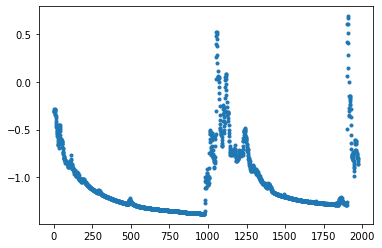

In [81]:
plt.plot(np.log10(h.history['loss']), '.')

In [82]:
outs['v'].eval([x_data, z_data])

array([3500., 3500., 3500., ..., 3500., 3500., 3500.], dtype=float32)

In [83]:
pred = outs['T'].eval([x_data, z_data]).reshape(nx, nz)

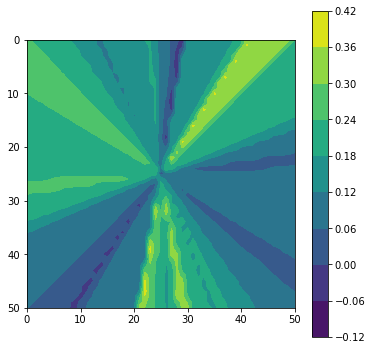

In [84]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex='col', sharey='row', figsize=(6, 6))

im = ax.contourf(pred.T)
ax.set_ylim([nz, 0])
ax.axis('scaled')
plt.colorbar(mappable=im, ax=ax)
plt.show()

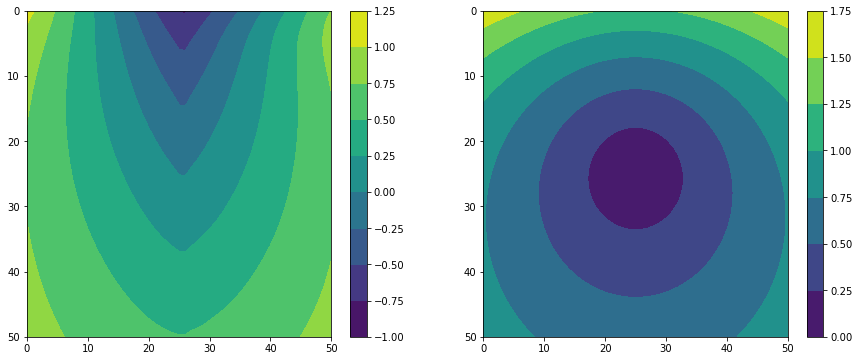

In [28]:
pred = _T.eval([x_data, z_data])
# pred -= Sl
# pred *= 100 / Sl
# pred *= scaler / vmax
pred = pred.reshape(nx, nz)
plt.figure(figsize=(15,6))

plt.subplot(121)
im = plt.contourf(pred.T)
plt.ylim([50, 0])
plt.colorbar(im)

plt.subplot(122)
im = plt.contourf(T.T * vmax / scaler)
plt.ylim([50, 0])
plt.colorbar(im)

In [22]:
losses = list(h.history.values())

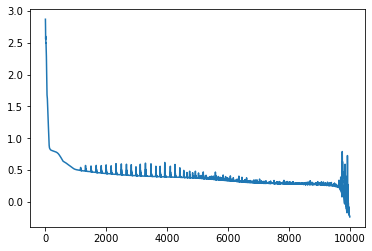

In [23]:
plt.plot(np.log10(losses[0]), )